# Spam Detection

The goal of this project is to train the Neural Network to classify between Spam and Non-Spam emails. And then finding which columns effect the decision the most. Then the model is run again that doesn't use 1, 2, and 10 most significant parameters. 




# Project Overview

###### The project can be summarized in the following steps:


##### Step 1:
A simple 2 layer Neural Network is build
##### Step 2:
More sophisticated Neural Network is build
##### Step 3:
Testing the model and predicting on unseen 5% Test data
##### Step 4:
Cross validation to improve the model performance and predicting  again on test data
##### Step 5:
Comparing the final model with other ML models
##### Step 6:
Finding gradients of all the Spam and Non-Spam records
##### Step 7:
Finding top 1, 2 and 10 columns with highest gradient (for Spam, non-Spam and the entire dataset)
##### Step 8:
Re-running the model without 1,2 and 10 most significant columns and infer results


## Loading necessary libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import tensorflow as tf
from collections import defaultdict

import csv
import sklearn
from sklearn import linear_model
from scipy.io import mmread

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Read the dataset

The data is stored in data directory. In this directory all original data is stored along with the file `columns.txt` which is extracted from `spambase.names` and contain the words used in spam database. This file is used later in this notebook.

Lets read the data

In [17]:
x = []
y = []
with open('data/spambase.data', 'rt') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for raw in data:
        x.append(np.array(raw[:-1], dtype=np.float32))
        y.append(int(raw[-1]))
        
x = np.array(x)
y = np.array(y)

Lets normalize the data so that all values remain between 0 and 1 and are comparable

In [18]:
n_ch = x.shape[-1]

#normalize inputs
for ch in range(n_ch):
	ch_v = x[:, ch]
	norm = ch_v.max()
	x[:, ch] /= norm

print (x.shape, y.shape)

(4601, 57) (4601,)


Lets also load the additional columns file

In [19]:
col_names=[]
with open('data/columns.txt', 'r') as doc:
    col_names=doc.read().splitlines()
    
len(col_names)

58

Load data in a dataframe and have a look at the sample

In [20]:
df = pd.DataFrame(np.append(x,y.reshape(y.shape[0],1),axis = 1), columns=col_names)
df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [21]:
X = df.loc[:, df.columns!= 'class']
y = df['class']

# STEP 1: Building the Neural Network

As first step, we just created a simple 2 layer neural network (dim n_input -> 1, activation sigmoid) and passed all data with a **random of 80 : 20** split for training and validation. No test set was reserved.  

In [22]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3680, 57)
(921, 57)
(3680,)
(921,)


In [23]:
n_input = X_train.shape[1]
#n_output = 2
n_output = 1

#### Defining the simple network

In [388]:
x = tf.keras.layers.Input(name='X', dtype=tf.float64, shape=[n_input])

#layer 1: 10 inputs -> 4, sigmoid activation
l1 = tf.keras.layers.Dense(units=n_input, name='L1', activation='relu')(x)

#layer 2: 4 inputs -> 2, softmax activation
#l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1)
l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='sigmoid')(l1)

model = tf.keras.Model(inputs=x, outputs=l2)

#specify optimizer and compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 57)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 57)                3306      
_________________________________________________________________
L2 (Dense)                   (None, 1)                 58        
Total params: 3,364
Trainable params: 3,364
Non-trainable params: 0
_________________________________________________________________


#### Execute the simple NN for 50 epocs (lr: 0.002), batch = 50

80% of the spam data would be used for training and 20% for testing

In [389]:
#epochs=50, batch_size=50 
hist = model.fit(x=X_train, y=y_train, epochs=50, batch_size=50, verbose=1, validation_data=(X_test, y_test),)

Epoch 1/50
88/88 [==============================] - 0s 5ms/step - loss: 0.5587 - accuracy: 0.7794 - val_loss: 0.4270 - val_accuracy: 0.8745
Epoch 2/50
88/88 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.8835 - val_loss: 0.3296 - val_accuracy: 0.8831
Epoch 3/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2730 - accuracy: 0.9078 - val_loss: 0.3014 - val_accuracy: 0.9048
Epoch 4/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2443 - accuracy: 0.9156 - val_loss: 0.2826 - val_accuracy: 0.9091
Epoch 5/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2252 - accuracy: 0.9217 - val_loss: 0.2766 - val_accuracy: 0.9004
Epoch 6/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2146 - accuracy: 0.9252 - val_loss: 0.2690 - val_accuracy: 0.9048
Epoch 7/50
88/88 [==============================] - 0s 2ms/step - loss: 0.2063 - accuracy: 0.9291 - val_loss: 0.2630 - val_accuracy: 0.9004
Epoch 8/50
88/88 [==

Lets visualize the results

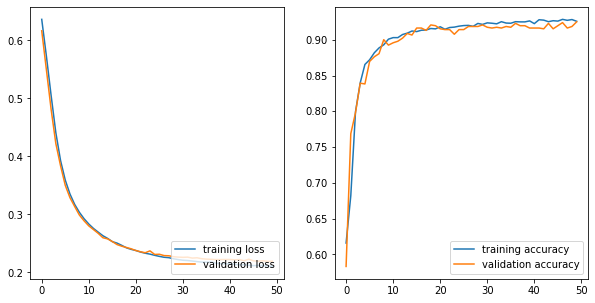

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [27]:
acc = hist.history['accuracy'][-1]
vac = hist.history['val_accuracy'][-1]

print(f'Final training accuracy  : {acc}')
print(f'Final validation accuracy: {vac}')

Final training accuracy  : 0.925815224647522
Final validation accuracy: 0.9250814318656921


Here we had no dedicated test set to test predictions.

# STEP 2: Building a more sophisticated Neural Network

Now we will create a more sophisticated Dense Neural network with a few hidden layers. The rest of the approach would still be the same as above. 


In [28]:
model = None
dim_input = n_input
x = tf.keras.layers.Input(name = 'X', dtype =  tf.float32, shape = dim_input)
    
#1 layer: 57 inputs -> 60 outputs, sigmoid activation
l1 = tf.keras.layers.Dense(units=60, name='L1', activation = 'sigmoid')(x)

#layer 2: 60 inputs -> 30 output, sigmoid activation
l2 = tf.keras.layers.Dense(units=30, name='L2', activation='sigmoid')(l1)

#layer 3: 30 inputs -> 10 output, sigmoid activation
l3 = tf.keras.layers.Dense(units=10, name='L3', activation='sigmoid')(l2)

#layer 4: 10 inputs -> 1 output, sigmoid activation
l4 = tf.keras.layers.Dense(units=1, name='L4', activation='sigmoid')(l3)

model =  tf.keras.Model(inputs=x, outputs=l4)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 57)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3480      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,631
Trainable params: 5,631
Non-trainable params: 0
_________________________________________________________________


#### Execute the simple NN for 50 epocs (lr: 0.002), batch = 50

80 of the spam data would be used for training and 20% for testing

In [29]:
#epochs=50, batch_size=50 
hist = model.fit(x=X_train, y=y_train, epochs=50, batch_size=50, verbose=1, validation_data=(X_test, y_test),)

Epoch 1/50
74/74 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.6133 - val_loss: 0.6746 - val_accuracy: 0.5765
Epoch 2/50
74/74 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.6133 - val_loss: 0.6344 - val_accuracy: 0.5765
Epoch 3/50
74/74 [==============================] - 0s 2ms/step - loss: 0.5401 - accuracy: 0.7277 - val_loss: 0.4511 - val_accuracy: 0.8404
Epoch 4/50
74/74 [==============================] - 0s 2ms/step - loss: 0.3732 - accuracy: 0.8698 - val_loss: 0.3315 - val_accuracy: 0.8882
Epoch 5/50
74/74 [==============================] - 0s 2ms/step - loss: 0.3055 - accuracy: 0.8932 - val_loss: 0.2865 - val_accuracy: 0.9045
Epoch 6/50
74/74 [==============================] - 0s 1ms/step - loss: 0.2754 - accuracy: 0.9065 - val_loss: 0.2636 - val_accuracy: 0.9121
Epoch 7/50
74/74 [==============================] - 0s 2ms/step - loss: 0.2587 - accuracy: 0.9098 - val_loss: 0.2480 - val_accuracy: 0.9251
Epoch 8/50
74/74 [==

Lets visualize the results

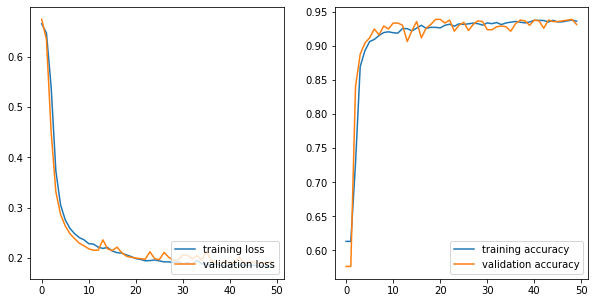

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [31]:
acc = hist.history['accuracy'][-1]
vac = hist.history['val_accuracy'][-1]

print(f'Final training accuracy  : {acc}')
print(f'Final validation accuracy: {vac}')

Final training accuracy  : 0.936413049697876
Final validation accuracy: 0.9315961003303528


There was some improvement but without a held-out test set, it is difficult to say the estimated overall accuracy.

# STEP 3: Keeping a seperate test set

The data is not huge, just a couple of thousand records. So it doesn't make sense to have a 80:20 split. Lets make a 95:05 split. In the training data, we still keep a 80:20 split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4370, 57)
(231, 57)
(4370,)
(231,)


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(3496, 57)
(874, 57)
(3496,)
(874,)


Lets define a helper function for our predictions based on test set

In [34]:
def predict_model(model, X, Y):
    predict = model.predict(X)
    # if probability is >0.5, its 1 -> spam, otherwise non-spam
    predict = [1 if out>0.5 else 0 for out in predict]
    return(accuracy_score(Y, predict))
#we can also return f1 score or other metrics of classification. these are sklearn built in methods

We reuse the multi layer NN above for training.

In [35]:
model = None

x = tf.keras.layers.Input(name = 'X', dtype =  tf.float32, shape = dim_input)
    
#1 layer: 57 inputs -> 60 outputs, sigmoid activation
l1 = tf.keras.layers.Dense(units=60, name='L1', activation = 'sigmoid')(x)

#layer 2: 60 inputs -> 30 output, sigmoid activation
l2 = tf.keras.layers.Dense(units=30, name='L2', activation='sigmoid')(l1)

#layer 3: 30 inputs -> 10 output, sigmoid activation
l3 = tf.keras.layers.Dense(units=10, name='L3', activation='sigmoid')(l2)

#layer 4: 10 inputs -> 1 output, sigmoid activation
l4 = tf.keras.layers.Dense(units=1, name='L4', activation='sigmoid')(l3)

model =  tf.keras.Model(inputs=x, outputs=l4)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 57)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3480      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,631
Trainable params: 5,631
Non-trainable params: 0
_________________________________________________________________


In [36]:
hist = model.fit(x=X_train, y=y_train, epochs=50, batch_size=50, verbose=1, validation_data=(X_val, y_val),)

Epoch 1/50
70/70 [==============================] - 0s 4ms/step - loss: 0.6678 - accuracy: 0.6104 - val_loss: 0.6661 - val_accuracy: 0.6018
Epoch 2/50
70/70 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6101 - val_loss: 0.6264 - val_accuracy: 0.6018
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.5471 - accuracy: 0.7243 - val_loss: 0.4566 - val_accuracy: 0.8227
Epoch 4/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3681 - accuracy: 0.8739 - val_loss: 0.3398 - val_accuracy: 0.8684
Epoch 5/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2954 - accuracy: 0.8959 - val_loss: 0.3071 - val_accuracy: 0.8879
Epoch 6/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2654 - accuracy: 0.9110 - val_loss: 0.2920 - val_accuracy: 0.8913
Epoch 7/50
70/70 [==============================] - 0s 2ms/step - loss: 0.2489 - accuracy: 0.9142 - val_loss: 0.2809 - val_accuracy: 0.8982
Epoch 8/50
70/70 [==

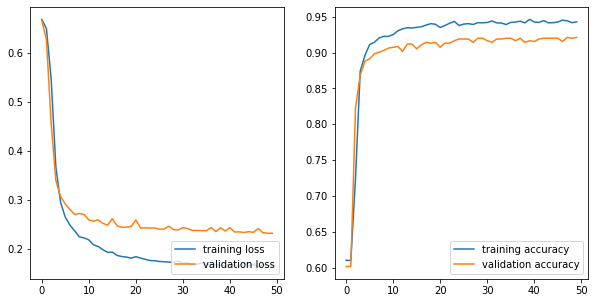

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [38]:
acc = hist.history['accuracy'][-1]
vac = hist.history['val_accuracy'][-1]

print(f'Final training accuracy  : {acc}')
print(f'Final validation accuracy: {vac}')

Final training accuracy  : 0.942791759967804
Final validation accuracy: 0.9210526347160339


Testing the model with `Test Set`

In [39]:
predict_model(model, X_test, y_test)

0.9134199134199135

Not a lot of Improvement !!!

# STEP 4: Doing K-Fold cross validation training

Let's define some helper functions first

##### nn_Classifier (returns model)
##### train_model (trains and returns fitted model)
##### predict_model (prediction on test set, returns predicted probability)
##### cross_validation (4 fold cross validation on any model, returns 4 accuracies and average accuracy)

In [40]:
def nn_classifier(dim_input=1, learning_rate=0.02):

    x = tf.keras.layers.Input(name = 'X', dtype =  tf.float32, shape = dim_input)
    #1 layer: 57 inputs -> 60 outputs, sigmoid activation
    l1 = tf.keras.layers.Dense(units=60, name='L1', activation = 'sigmoid')(x)
    #layer 2: 60 inputs -> 30 output, sigmoid activation
    l2 = tf.keras.layers.Dense(units=30, name='L2', activation='sigmoid')(l1)
    #layer 3: 30 inputs -> 10 output, sigmoid activation
    l3 = tf.keras.layers.Dense(units=10, name='L3', activation='sigmoid')(l2)
    #layer 4: 10 inputs -> 1 output, sigmoid activation
    l4 = tf.keras.layers.Dense(units=1, name='L4', activation='sigmoid')(l3)
    
    # Softmax is used for multi-classification in the Logistic Regression model, 
    # whereas Sigmoid is used for binary classification in the Logistic Regression model

    model =  tf.keras.Model(inputs=x, outputs=l4)

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return(model)

In [41]:
def train_model (model, X, Y, epochs = 500, batch_size = 1000, params = None):
    #batch size set high enough to ensure that all of the samples are passed through the network in each epoch
    #if model is functional, then trains with neural network other wise random forest/decision tree
    if model.__class__.__name__ == 'Functional':
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
        return model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_test, y_test))
    else:
        return model.fit(X, Y)

In [42]:
#testing via k fold cross-validation.
def cross_validation(model, X, Y, folds = 10, epochs = 500, seed=1, batch_size = 1000):
    
    k_fold = KFold(n_splits=folds, shuffle=True, random_state=seed)
    
    #initializing empty array for the validation set
    validation_accuracy = []
    #split returns indexes 
    
    hist = defaultdict(list)
    for train_Idx, test_Idx in k_fold.split(X):
        
        #if the model is functional, means if its our neural network, it takes epochs, batchsize and starts training
        if model.__class__.__name__ == 'Functional':
            h = train_model(model, X.iloc[train_Idx,:], Y.iloc[train_Idx], epochs = epochs, batch_size = batch_size)
            for hkey in h.history.keys():
                hist[hkey].append(h.history[hkey])
            h.history=hist
            
        #else does decision tree, random forest to compare the accuracies of all different models
        else:
            hist = train_model(model, X.iloc[train_Idx,:], Y.iloc[train_Idx])
        
        #now prediction on the test set, that was split by k_fold.split
        preds = predict_model(model,X.iloc[test_Idx,:], Y.iloc[test_Idx])
        #validation array gets updated by 10 outputs done by cross validation, and gets returned
        validation_accuracy.append(preds)
        
    res = {'validation_accuracy': validation_accuracy, 'Avg_Accuracy': np.average(validation_accuracy)}
    if model.__class__.__name__ == 'Functional':
        for hkey in h.history.keys():
            h.history[hkey]= np.average(np.array(h.history[hkey]), axis=0)
        return (model, res, h)
    return(model, res)

we use the same Train, Val and Test splits 

In [43]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4370, 57)
(874, 57)
(231, 57)
(4370,)
(874,)
(231,)


In [78]:
model = None
model = nn_classifier(dim_input=np.shape(X)[1], learning_rate = 0.003)
model.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 57)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3480      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,631
Trainable params: 5,631
Non-trainable params: 0
_________________________________________________________________


We train the model with 4-fold cross validation

Also increase the epocs to 100

In [79]:
model, res, hist = cross_validation(model, X_train, y_train, folds = 4, epochs = 100, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.6443 - accuracy: 0.6307 - val_loss: 0.4554 - val_accuracy: 0.8796
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2993 - accuracy: 0.8951 - val_loss: 0.2682 - val_accuracy: 0.9101
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.9199 - val_loss: 0.2600 - val_accuracy: 0.9116
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9195 - val_loss: 0.2387 - val_accuracy: 0.9223
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2131 - accuracy: 0.9248 - val_loss: 0.2449 - val_accuracy: 0.9101
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2051 - accuracy: 0.9283 - val_loss: 0.2320 - val_accuracy: 0.9238
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9283 - val_loss: 0.2182 - val_accuracy: 0.9299
Epoch 8/50
53/53 [==

Epoch 9/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.9493 - val_loss: 0.1756 - val_accuracy: 0.9390
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9523 - val_loss: 0.1806 - val_accuracy: 0.9405
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1265 - accuracy: 0.9519 - val_loss: 0.2037 - val_accuracy: 0.9223
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1264 - accuracy: 0.9527 - val_loss: 0.1857 - val_accuracy: 0.9421
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1254 - accuracy: 0.9527 - val_loss: 0.1874 - val_accuracy: 0.9375
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9519 - val_loss: 0.1828 - val_accuracy: 0.9299
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1243 - accuracy: 0.9535 - val_loss: 0.1815 - val_accuracy: 0.9360
Epoch 16/50
53

53/53 [==============================] - 0s 2ms/step - loss: 0.1023 - accuracy: 0.9645 - val_loss: 0.0985 - val_accuracy: 0.9680
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1069 - accuracy: 0.9626 - val_loss: 0.1196 - val_accuracy: 0.9619
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0999 - accuracy: 0.9657 - val_loss: 0.1048 - val_accuracy: 0.9634
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1009 - accuracy: 0.9634 - val_loss: 0.1039 - val_accuracy: 0.9588
Epoch 21/50
53/53 [==============================] - 0s 1ms/step - loss: 0.0967 - accuracy: 0.9661 - val_loss: 0.1070 - val_accuracy: 0.9634
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1020 - accuracy: 0.9657 - val_loss: 0.1079 - val_accuracy: 0.9665
Epoch 23/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0998 - accuracy: 0.9649 - val_loss: 0.1054 - val_accuracy: 0.9665
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9840 - val_loss: 0.1332 - val_accuracy: 0.9665
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 0.9836 - val_loss: 0.1260 - val_accuracy: 0.9665
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9832 - val_loss: 0.1367 - val_accuracy: 0.9634
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0494 - accuracy: 0.9855 - val_loss: 0.1236 - val_accuracy: 0.9680
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0519 - accuracy: 0.9828 - val_loss: 0.1448 - val_accuracy: 0.9634
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0567 - accuracy: 0.9809 - val_loss: 0.1237 - val_accuracy: 0.9680
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.0531 - accuracy: 0.9828 - val_loss: 0.1256 - val_accuracy: 0.9695
Epoch 32/50
53/53 [======

In [80]:
model,res

(<tensorflow.python.keras.engine.functional.Functional at 0x237b923bc70>,
 {'validation_accuracy': [0.9377859103385179,
   0.9451052150045746,
   0.9441391941391941,
   0.9468864468864469],
  'Avg_Accuracy': 0.9434791915921834})

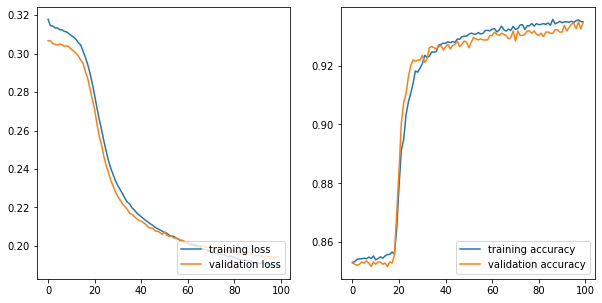

In [70]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='lower right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])
axs[1].legend(('training accuracy','validation accuracy'), loc='lower right')
plt.show()

In [81]:
acc = hist.history['accuracy'][-1]
vac = hist.history['val_accuracy'][-1]

print(f'Final training accuracy  : {acc}')
print(f'Final validation accuracy: {vac}')

Final training accuracy  : 0.9696716815233231
Final validation accuracy: 0.9466463327407837


#### Evaluate model with test set

In [82]:
preds = predict_model(model,X_test, y_test)
preds

0.9393939393939394

Tiny bit improvement

### Lets compare with other standard ML Models 

In [83]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=10000)
cross_validation(LR, X, y)

(LogisticRegression(max_iter=10000),
 {'validation_accuracy': [0.9023861171366594,
   0.9065217391304348,
   0.8760869565217392,
   0.8847826086956522,
   0.8826086956521739,
   0.8630434782608696,
   0.9,
   0.8978260869565218,
   0.8934782608695652,
   0.9108695652173913],
  'Avg_Accuracy': 0.8917603508441008})

#### Logistic Regression: ~0.89%

In [84]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
cross_validation(decision_tree, X, y)

(DecisionTreeClassifier(),
 {'validation_accuracy': [0.9088937093275488,
   0.9152173913043479,
   0.9369565217391305,
   0.9,
   0.9260869565217391,
   0.9130434782608695,
   0.908695652173913,
   0.9434782608695652,
   0.9021739130434783,
   0.9065217391304348],
  'Avg_Accuracy': 0.9161067622371026})

#### DecisionTreeClassifier: ~91%

In [85]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
cross_validation(random_forest, X, y)

(RandomForestClassifier(),
 {'validation_accuracy': [0.9587852494577006,
   0.9608695652173913,
   0.9521739130434783,
   0.941304347826087,
   0.9521739130434783,
   0.9434782608695652,
   0.9521739130434783,
   0.9717391304347827,
   0.967391304347826,
   0.9608695652173913],
  'Avg_Accuracy': 0.9560959162501179})

#### RandomForestClassifier: ~95%
**WoW**

# Step 4: Parameter effect on gradients

We take the last 4-fold cross validated model

Sample index: 40

In [218]:
#ev_loss, ev_acc=model.evaluate(x_val, y_val)
#print(ev_loss, ev_acc)

#Obatin partial derivative  input wrt output for one observation
idx = 1
inp_v = X[idx:idx+1]  # use one row to compute gradients with respect to


inp = tf.constant(inp_v)  # create tf constant tensor, are fixed values and hence not trainable
with tf.GradientTape() as tape:  # gradient tape for gradint evaluation, initialize as tape
    tape.watch(inp)  # take inp as variable
    prediction = model(inp) # evaluate model output

grads = tape.jacobian(prediction, inp)  # evaluate d preds[i] / d inp[j]


In [348]:
grads

<tf.Tensor: shape=(1, 1, 1, 57), dtype=float64, numpy=
array([[[[ 0.0000089215, -0.0000020519, -0.0000025384, -0.000000551 ,
           0.0000038598, -0.0000010172,  0.0000017262,  0.0000016244,
           0.0000071477, -0.000002522 , -0.0000009522,  0.0000004859,
           0.0000026235, -0.0000038238,  0.0000013546, -0.0000150389,
           0.0000107025,  0.0000039015,  0.0000023945,  0.0000015669,
          -0.0000013357,  0.0000008688, -0.0000177597,  0.0000065532,
          -0.0000036936, -0.0000051686,  0.0000136006,  0.0000034713,
          -0.0000011673, -0.000002993 ,  0.0000047425, -0.0000064296,
          -0.0000044179,  0.0000126772,  0.0000131266, -0.0000014541,
           0.0000001362,  0.000002676 , -0.0000051678,  0.0000016911,
          -0.0000025138,  0.0000033789, -0.0000060675, -0.0000004087,
           0.0000029043,  0.0000008481, -0.0000035426, -0.0000030842,
          -0.0000041815, -0.0000014396, -0.000001115 ,  0.0000121113,
           0.0000042062, -0.0000154

In [219]:
print(f'Predicted probability: {list(prediction.numpy().squeeze(axis=1))}')
print(f'Predicted class      : {list(np.squeeze(tf.where(prediction < 0.5, 0, 1), axis=1))}')
print(f'Actual class         : {list(y[idx:idx+1].astype(int))}')

Predicted probability: [0.9998938]
Predicted class      : [1]
Actual class         : [1]


In [392]:
np.set_printoptions(precision=10, suppress=True)

#extract index top 10 gradient
n=10
for gg in grads:
    #print(np.argmax(gg[1]))
    bla=np.absolute(gg[0][0].numpy())
    #idxx = np.argpartition(bla[0], -n)[-n:]
    #indices = idxx[np.argsort((-bla[0])[idxx])]
    indices = np.argsort(bla)[::-1][:n]
    
    print(indices)

[22 53 15 26 34 33 51 55 16  0]


In [229]:
extr_ind= [numb for numb in indices]
print(np.array(col_names).reshape(58)[extr_ind])

['word_freq_000' 'char_freq_#' 'word_freq_free' 'word_freq_george'
 'word_freq_85' 'word_freq_415' 'char_freq_!' 'capital_run_length_longest'
 'word_freq_business' 'word_freq_make']


## checking the gradients of all spam/non-spam records



#### first create a confusion matrix

Then we'll take all the true positives and ture negatives and find all most repeating columns with maximum gradients



In [230]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

In [231]:
y_true = y.astype(int).values.tolist()
y_pred = list(tf.where(model(tf.constant(X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

 number of instances =  4601
 attributes: 57 float, 1 class

Spam  1813  (39.4%) initially in the dataset
Non-Spam  2788  (60.6%) initially in the dataset


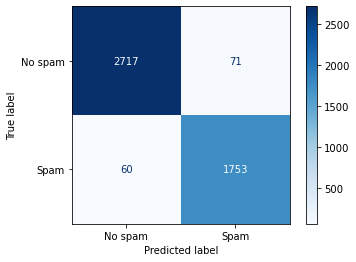

In [232]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

TP ~2.7k, no spam

FP >100, actually spam, but predicted no spam

FN >50, actually no spam, but predicted spam

TN ~1.7k, actually spam, predicted spam

pos-nospam, neg-spam

#### getting all the spam and non spam values in variables idx_0 and idx_1

In [233]:
y_sum = [sum(x) for x in zip(y_true, y_pred) ]

idx_0 = [1 if x==0 else 0 for x in y_sum] #1 assigned to the non-spams in the list, 0 assigned to wrong prediction
idx_1 = [1 if x==2 else 0 for x in y_sum] #1 assigned to the spams in the list, 0 assigned to wrong prediction

In [234]:
from collections import defaultdict

def get_grads(idx, n=10):
    #d0 = defaultdict(int)
    #idx = np.array(idx_lst,dtype=bool)
    inp_v = X[idx:idx+1]  # use one row to compute gradients with respect to

    inp = tf.constant(inp_v)  # create tf constant tensor, are fixed values and hence not trainable
    with tf.GradientTape() as tape:  # gradient tape for gradint evaluation, initialize as tape
        tape.watch(inp)  # take inp as variable
        preds = model(inp) # evaluate model output

    grads = tape.jacobian(preds, inp)  # evaluate d preds[i] / d inp[j]

    #extract index top 10 gradients
    
    #for gg in grads:
    #    #print(np.argmax(gg[1]))
    #    bla=gg[0].numpy()
    #    idxx = np.argpartition(bla[0], -n)[-n:]
    #    indices = idxx[np.argsort((-bla[0])[idxx])]
    for gg in grads:
        bla=np.absolute(gg[0][0].numpy())#gg[0][0].numpy()
        indices = np.argsort(bla)[::-1][:n]
    
    return indices
    #return [x for (x,y) in sorted(d0.items(), key=lambda x: x[1], reverse=True)[:n]]

def get_n_grads(lst, n=10, reverse=True):
    d0 = defaultdict(int)
    idx_list = list(X[np.array(lst,dtype=bool)].index) #first boolean of 1 and 0, then x for that true values(only those records), then index
    for x, l in enumerate(idx_list): #l has indices of spam records, x has actual record index
        indices = get_grads(l, n) #top 4 gradients for all spam records
        for i in indices: #looks all records, if repeatitive gradient, it sums up 
            d0[i] += 1
        if (x+1) % 500 == 0 or (x+1)==len(idx_list):
            print(f'{x+1}/{len(idx_list)} complete')
        #print(x)
    return [x for (x,y) in sorted(d0.items(), key=lambda x: x[1], reverse=reverse)][:n]  #sorting on values, until n elements

In [242]:
%%time
extr_ind_1 = get_n_grads(idx_1, 10, reverse=False)

500/1753 complete
1000/1753 complete
1500/1753 complete
1753/1753 complete
Wall time: 6min 9s


In [244]:
print("Top 10 fields for spam are")
print(np.array(col_names).reshape(58)[extr_ind_1])

Top 10 fields for spam are
['word_freq_technology' 'word_freq_people' 'word_freq_your'
 'word_freq_report' 'word_freq_receive' 'word_freq_money'
 'word_freq_table' 'char_freq_;' 'word_freq_you' 'word_freq_re']


In [240]:
%%time
extr_ind_0 = get_n_grads(idx_0, 10, reverse=True)

500/2717 complete
1000/2717 complete
1500/2717 complete
2000/2717 complete
2500/2717 complete
2717/2717 complete
Wall time: 10min 9s


In [241]:
print("Top 10 fields for non spam are")
print(np.array(col_names).reshape(58)[extr_ind_0])

Top 10 fields for non spam are
['word_freq_cs' 'capital_run_length_average' 'char_freq_!'
 'word_freq_george' 'capital_run_length_longest' 'word_freq_telnet'
 'word_freq_edu' 'word_freq_hp' 'word_freq_85' 'word_freq_font']


In [245]:
print("Top 10 fields for spam are")
print(np.array(col_names).reshape(58)[extr_ind_1])

print("Top 10 fields for non spam are")
print(np.array(col_names).reshape(58)[extr_ind_0])

Top 10 fields for spam are
['word_freq_technology' 'word_freq_people' 'word_freq_your'
 'word_freq_report' 'word_freq_receive' 'word_freq_money'
 'word_freq_table' 'char_freq_;' 'word_freq_you' 'word_freq_re']
Top 10 fields for non spam are
['word_freq_cs' 'capital_run_length_average' 'char_freq_!'
 'word_freq_george' 'capital_run_length_longest' 'word_freq_telnet'
 'word_freq_edu' 'word_freq_hp' 'word_freq_85' 'word_freq_font']


Common input in spam are people, your & you, indicating spammer does not know you in person. 
Also in spam are words like money, receive, report and technology, words which are common in spam email.

On the other hand, words like george, hp and 85 appeared in non spam, which mostly point to a specific entity. Also words like ca font and telnet are uncommon in spam email

#### Getting all the columns for the entire dataset in order of significance (effect on the decision of the classifier)

In [247]:
extr_ind = get_n_grads([1]*len(X), 57)

500/4601 complete
1000/4601 complete
1500/4601 complete
2000/4601 complete
2500/4601 complete
3000/4601 complete
3500/4601 complete
4000/4601 complete
4500/4601 complete
4601/4601 complete


In [249]:
print(np.array(col_names).reshape(58)[extr_ind])

['word_freq_edu' 'word_freq_font' 'word_freq_cs'
 'capital_run_length_average' 'capital_run_length_longest'
 'word_freq_credit' 'char_freq_!' 'word_freq_george'
 'word_freq_conference' 'word_freq_hp' 'word_freq_3d' 'word_freq_parts'
 'char_freq_$' 'capital_run_length_total' 'word_freq_business'
 'word_freq_direct' 'word_freq_our' 'word_freq_remove'
 'word_freq_original' 'char_freq_[' 'word_freq_650' 'word_freq_order'
 'word_freq_pm' 'word_freq_internet' 'word_freq_lab' 'char_freq_#'
 'word_freq_hpl' 'word_freq_free' 'word_freq_addresses' 'word_freq_1999'
 'word_freq_857' 'char_freq_(' 'word_freq_people' 'word_freq_make'
 'word_freq_address' 'word_freq_money' 'word_freq_will'
 'word_freq_project' 'word_freq_table' 'char_freq_;' 'word_freq_re'
 'word_freq_you' 'word_freq_data' 'word_freq_receive' 'word_freq_mail'
 'word_freq_all' 'word_freq_report' 'word_freq_your' 'word_freq_meeting'
 'word_freq_85' 'word_freq_415' 'word_freq_email' 'word_freq_000'
 'word_freq_labs' 'word_freq_technolog

In [ ]:
extr_ind

#### Removing top 10 most significant columns

In [269]:
#removing top 10 most important columns
new_df= df.drop(['word_freq_edu','word_freq_font','word_freq_cs','capital_run_length_average', 'capital_run_length_longest',
                  'word_freq_credit','char_freq_!','word_freq_george','word_freq_conference','word_freq_hp'], axis=1)

In [270]:
new_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_project,word_freq_re,word_freq_table,char_freq_;,char_freq_(,char_freq_[,char_freq_$,char_freq_#,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.0,0.0,0.0,0.013536,0.0,0.029985,0.002421,0.064895,1.0


In [271]:
new_X = new_df.loc[:, new_df.columns!= 'class']
new_Y = new_df['class']

In [272]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_Y, test_size=0.05, random_state=0)


In [273]:
new_model = nn_classifier(dim_input=np.shape(new_X_train)[1], learning_rate = 0.003)
new_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 47)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                2880      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,031
Trainable params: 5,031
Non-trainable params: 0
_________________________________________________________________


In [274]:
new_model, new_res, new_hist = cross_validation(new_model, new_X_train, new_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5887 - val_loss: 0.6736 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.6185 - val_loss: 0.6626 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6277 - accuracy: 0.6276 - val_loss: 0.5876 - val_accuracy: 0.6631
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4796 - accuracy: 0.8119 - val_loss: 0.4022 - val_accuracy: 0.8491
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3697 - accuracy: 0.8604 - val_loss: 0.3651 - val_accuracy: 0.8506
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3445 - accuracy: 0.8680 - val_loss: 0.3359 - val_accuracy: 0.8704
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3142 - accuracy: 0.8859 - val_loss: 0.3228 - val_accuracy: 0.8780
Epoch 8/50
53/53 [==

53/53 [==============================] - 0s 2ms/step - loss: 0.2433 - accuracy: 0.9172 - val_loss: 0.2618 - val_accuracy: 0.9009
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2430 - accuracy: 0.9161 - val_loss: 0.2663 - val_accuracy: 0.9009
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9180 - val_loss: 0.2566 - val_accuracy: 0.9085
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.9180 - val_loss: 0.2709 - val_accuracy: 0.9009
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.9168 - val_loss: 0.2565 - val_accuracy: 0.9085
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2392 - accuracy: 0.9164 - val_loss: 0.2566 - val_accuracy: 0.9085
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2439 - accuracy: 0.9149 - val_loss: 0.2569 - val_accuracy: 0.9085
Epoch 16/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.2341 - accuracy: 0.9130 - val_loss: 0.2255 - val_accuracy: 0.9192
Epoch 18/50
53/53 [==============================] - 0s 1ms/step - loss: 0.2329 - accuracy: 0.9142 - val_loss: 0.2211 - val_accuracy: 0.9085
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2338 - accuracy: 0.9142 - val_loss: 0.2214 - val_accuracy: 0.9146
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2327 - accuracy: 0.9142 - val_loss: 0.2350 - val_accuracy: 0.9146
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.9157 - val_loss: 0.2372 - val_accuracy: 0.9146
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2361 - accuracy: 0.9142 - val_loss: 0.2216 - val_accuracy: 0.9146
Epoch 23/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2358 - accuracy: 0.9115 - val_loss: 0.2321 - val_accuracy: 0.9131
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.2297 - accuracy: 0.9146 - val_loss: 0.2334 - val_accuracy: 0.9207
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2299 - accuracy: 0.9184 - val_loss: 0.2339 - val_accuracy: 0.9223
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9161 - val_loss: 0.2348 - val_accuracy: 0.9192
Epoch 28/50
53/53 [==============================] - 0s 1ms/step - loss: 0.2284 - accuracy: 0.9180 - val_loss: 0.2357 - val_accuracy: 0.9177
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2269 - accuracy: 0.9180 - val_loss: 0.2363 - val_accuracy: 0.9177
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2289 - accuracy: 0.9172 - val_loss: 0.2359 - val_accuracy: 0.9207
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2323 - accuracy: 0.9150 - val_loss: 0.2379 - val_accuracy: 0.9177
Epoch 32/50
53/53 [======

In [275]:
new_model,new_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237c083d6a0>,
 {'validation_accuracy': [0.909423604757548,
   0.9158279963403476,
   0.9038461538461539,
   0.9001831501831502],
  'Avg_Accuracy': 0.9073202262817999})

In [276]:
new_preds = predict_model(new_model,new_X_test, new_y_test)
new_preds

0.8787878787878788

In [277]:
new_y_true = new_Y.astype(int).values.tolist()
new_y_pred = list(tf.where(new_model(tf.constant(new_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

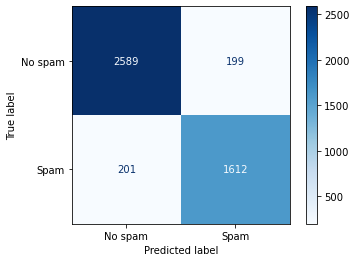

In [278]:
cm = confusion_matrix(new_y_true, new_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

#### Removing top 2 most significant columns

In [319]:

second_df= df.drop(['word_freq_edu','word_freq_font'], axis=1)

In [320]:
second_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [321]:
second_X = second_df.loc[:, second_df.columns!= 'class']
second_Y = second_df['class']

In [322]:
second_X_train, second_X_test, second_y_train, second_y_test = train_test_split(second_X, second_Y, test_size=0.05, random_state=0)

In [323]:
second_model = nn_classifier(dim_input=np.shape(second_X_train)[1], learning_rate = 0.003)
second_model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 55)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3360      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________


In [324]:
second_model, second_res, second_hist = cross_validation(second_model, second_X_train, second_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.6634 - accuracy: 0.6185 - val_loss: 0.6722 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6445 - accuracy: 0.6185 - val_loss: 0.6291 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5346 - accuracy: 0.7261 - val_loss: 0.4423 - val_accuracy: 0.8323
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8539 - val_loss: 0.3355 - val_accuracy: 0.8796
Epoch 5/50
53/53 [==============================] - 0s 3ms/step - loss: 0.3137 - accuracy: 0.8821 - val_loss: 0.3041 - val_accuracy: 0.8902
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2833 - accuracy: 0.9042 - val_loss: 0.2941 - val_accuracy: 0.8918
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2686 - accuracy: 0.9058 - val_loss: 0.2760 - val_accuracy: 0.8994
Epoch 8/50
53/53 [==

53/53 [==============================] - 0s 2ms/step - loss: 0.1912 - accuracy: 0.9355 - val_loss: 0.2011 - val_accuracy: 0.9299
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9382 - val_loss: 0.2060 - val_accuracy: 0.9314
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1868 - accuracy: 0.9386 - val_loss: 0.2040 - val_accuracy: 0.9314
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9332 - val_loss: 0.2076 - val_accuracy: 0.9314
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9359 - val_loss: 0.2013 - val_accuracy: 0.9284
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.9367 - val_loss: 0.2145 - val_accuracy: 0.9314
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9359 - val_loss: 0.2015 - val_accuracy: 0.9299
Epoch 16/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1813 - accuracy: 0.9382 - val_loss: 0.1762 - val_accuracy: 0.9345
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9382 - val_loss: 0.1687 - val_accuracy: 0.9436
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9344 - val_loss: 0.1990 - val_accuracy: 0.9268
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9405 - val_loss: 0.1693 - val_accuracy: 0.9436
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9359 - val_loss: 0.1692 - val_accuracy: 0.9436
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9394 - val_loss: 0.1690 - val_accuracy: 0.9390
Epoch 23/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9386 - val_loss: 0.1703 - val_accuracy: 0.9421
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9363 - val_loss: 0.1602 - val_accuracy: 0.9421
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9401 - val_loss: 0.1613 - val_accuracy: 0.9436
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9405 - val_loss: 0.1624 - val_accuracy: 0.9466
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9390 - val_loss: 0.1655 - val_accuracy: 0.9436
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9375 - val_loss: 0.1602 - val_accuracy: 0.9451
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1719 - accuracy: 0.9382 - val_loss: 0.1636 - val_accuracy: 0.9497
Epoch 31/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1732 - accuracy: 0.9405 - val_loss: 0.1630 - val_accuracy: 0.9482
Epoch 32/50
53/53 [======

In [325]:
second_model,second_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237c2f51400>,
 {'validation_accuracy': [0.9441903019213175,
   0.9268069533394327,
   0.9285714285714286,
   0.9184981684981685],
  'Avg_Accuracy': 0.9295167130825869})

In [326]:
second_preds = predict_model(second_model,second_X_test, second_y_test)
second_preds

0.9047619047619048

In [327]:
second_y_true = second_Y.astype(int).values.tolist()
second_y_pred = list(tf.where(second_model(tf.constant(second_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

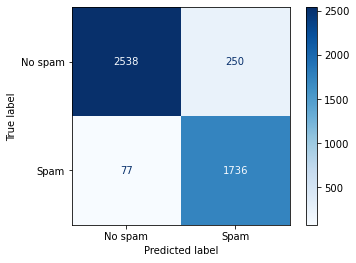

In [328]:
cm = confusion_matrix(second_y_true, second_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

#### Removing 1st most significant column

In [329]:

third_df= df.drop(['word_freq_edu'], axis=1)

In [330]:
third_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [331]:
third_X = third_df.loc[:, third_df.columns!= 'class']
third_Y = third_df['class']

In [332]:
third_X_train, third_X_test, third_y_train, third_y_test = train_test_split(third_X, third_Y, test_size=0.05, random_state=0)

In [333]:
third_model = nn_classifier(dim_input=np.shape(third_X_train)[1], learning_rate = 0.003)
third_model.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 56)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3420      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,571
Trainable params: 5,571
Non-trainable params: 0
_________________________________________________________________


In [334]:
third_model, third_res, third_hist = cross_validation(third_model, third_X_train, third_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 1s 14ms/step - loss: 0.7220 - accuracy: 0.5391 - val_loss: 0.6802 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6185 - val_loss: 0.6700 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6522 - accuracy: 0.6185 - val_loss: 0.6516 - val_accuracy: 0.5915
Epoch 4/50
53/53 [==============================] - 0s 3ms/step - loss: 0.6084 - accuracy: 0.6696 - val_loss: 0.5517 - val_accuracy: 0.7500
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.4569 - accuracy: 0.8432 - val_loss: 0.3778 - val_accuracy: 0.8689
Epoch 6/50
53/53 [==============================] - 0s 3ms/step - loss: 0.3465 - accuracy: 0.8783 - val_loss: 0.3216 - val_accuracy: 0.8872
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3054 - accuracy: 0.8882 - val_loss: 0.3030 - val_accuracy: 0.8979
Epoch 8/50
53/53 [=

53/53 [==============================] - 0s 2ms/step - loss: 0.1869 - accuracy: 0.9374 - val_loss: 0.2020 - val_accuracy: 0.9299
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.9386 - val_loss: 0.2143 - val_accuracy: 0.9345
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9340 - val_loss: 0.2034 - val_accuracy: 0.9299
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9401 - val_loss: 0.2028 - val_accuracy: 0.9299
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9348 - val_loss: 0.2006 - val_accuracy: 0.9284
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9382 - val_loss: 0.2046 - val_accuracy: 0.9314
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9378 - val_loss: 0.2032 - val_accuracy: 0.9299
Epoch 16/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9390 - val_loss: 0.1764 - val_accuracy: 0.9345
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9386 - val_loss: 0.1711 - val_accuracy: 0.9390
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9382 - val_loss: 0.1703 - val_accuracy: 0.9405
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1799 - accuracy: 0.9371 - val_loss: 0.1703 - val_accuracy: 0.9421
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.9371 - val_loss: 0.1843 - val_accuracy: 0.9329
Epoch 22/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1800 - accuracy: 0.9390 - val_loss: 0.1715 - val_accuracy: 0.9390
Epoch 23/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9378 - val_loss: 0.1810 - val_accuracy: 0.9299
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.9405 - val_loss: 0.1735 - val_accuracy: 0.9421
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.9466 - val_loss: 0.1811 - val_accuracy: 0.9360
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9420 - val_loss: 0.1792 - val_accuracy: 0.9360
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9439 - val_loss: 0.1737 - val_accuracy: 0.9421
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1727 - accuracy: 0.9443 - val_loss: 0.1692 - val_accuracy: 0.9466
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9424 - val_loss: 0.1753 - val_accuracy: 0.9405
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.9455 - val_loss: 0.1699 - val_accuracy: 0.9466
Epoch 32/50
53/53 [======

In [335]:
third_model,third_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237cabfaa90>,
 {'validation_accuracy': [0.9451052150045746,
   0.9268069533394327,
   0.9276556776556777,
   0.924908424908425],
  'Avg_Accuracy': 0.9311190677270276})

In [336]:
third_preds = predict_model(third_model,third_X_test, third_y_test)
third_preds

0.9004329004329005

In [337]:
third_y_true = third_Y.astype(int).values.tolist()
third_y_pred = list(tf.where(third_model(tf.constant(third_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

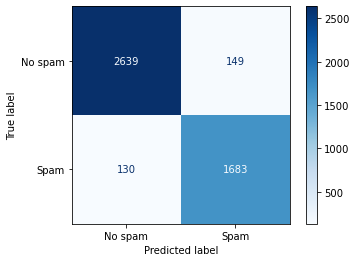

In [338]:
cm = confusion_matrix(third_y_true, third_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

#### Removing random 4 columns from the middle of the list (not so significant columns)

In [339]:

fourth_df= df.drop(['word_freq_pm','word_freq_internet','word_freq_lab','char_freq_#'], axis=1)
fourth_df.head(2)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_order,word_freq_mail,word_freq_receive,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.000000,0.0,0.023955,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.0,0.051705,0.08046,...,0.0,0.0,0.013536,0.0,0.011454,0.029985,0.004639,0.010111,0.064895,1.0


In [340]:
fourth_X = fourth_df.loc[:, fourth_df.columns!= 'class']
fourth_Y = fourth_df['class']

In [341]:
fourth_X_train, fourth_X_test, fourth_y_train, fourth_y_test = train_test_split(fourth_X, fourth_Y, test_size=0.05, random_state=0)
fourth_model = nn_classifier(dim_input=np.shape(fourth_X_train)[1], learning_rate = 0.003)
fourth_model.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 53)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3240      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [342]:
fourth_model, fourth_res, fourth_hist = cross_validation(fourth_model, fourth_X_train, fourth_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.6131 - val_loss: 0.6714 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6488 - accuracy: 0.6188 - val_loss: 0.6346 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5425 - accuracy: 0.7303 - val_loss: 0.4331 - val_accuracy: 0.8659
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8691 - val_loss: 0.3343 - val_accuracy: 0.8689
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.8928 - val_loss: 0.2997 - val_accuracy: 0.8902
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2720 - accuracy: 0.9050 - val_loss: 0.2842 - val_accuracy: 0.8948
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.9119 - val_loss: 0.2763 - val_accuracy: 0.8979
Epoch 8/50
53/53 [==

53/53 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9382 - val_loss: 0.2069 - val_accuracy: 0.9345
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9401 - val_loss: 0.2067 - val_accuracy: 0.9345
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9390 - val_loss: 0.2080 - val_accuracy: 0.9345
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.9424 - val_loss: 0.2076 - val_accuracy: 0.9329
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1829 - accuracy: 0.9401 - val_loss: 0.2089 - val_accuracy: 0.9345
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9390 - val_loss: 0.2156 - val_accuracy: 0.9345
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9374 - val_loss: 0.2089 - val_accuracy: 0.9314
Epoch 16/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.9378 - val_loss: 0.1662 - val_accuracy: 0.9375
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9386 - val_loss: 0.1735 - val_accuracy: 0.9360
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.9397 - val_loss: 0.1884 - val_accuracy: 0.9360
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9386 - val_loss: 0.1791 - val_accuracy: 0.9360
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9413 - val_loss: 0.1671 - val_accuracy: 0.9390
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1775 - accuracy: 0.9397 - val_loss: 0.1643 - val_accuracy: 0.9421
Epoch 23/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 0.9394 - val_loss: 0.1696 - val_accuracy: 0.9345
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9382 - val_loss: 0.1564 - val_accuracy: 0.9512
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9405 - val_loss: 0.1543 - val_accuracy: 0.9497
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1747 - accuracy: 0.9409 - val_loss: 0.1563 - val_accuracy: 0.9497
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9405 - val_loss: 0.1553 - val_accuracy: 0.9543
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1721 - accuracy: 0.9424 - val_loss: 0.1545 - val_accuracy: 0.9497
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9443 - val_loss: 0.1577 - val_accuracy: 0.9497
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9397 - val_loss: 0.1592 - val_accuracy: 0.9497
Epoch 32/50
53/53 [======

In [343]:
fourth_model,fourth_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237c755bd00>,
 {'validation_accuracy': [0.9460201280878316,
   0.9332113449222323,
   0.934981684981685,
   0.923992673992674],
  'Avg_Accuracy': 0.9345514579961058})

In [344]:
fourth_preds = predict_model(fourth_model,fourth_X_test, fourth_y_test)
fourth_preds

0.9004329004329005

In [345]:
fourth_y_true = fourth_Y.astype(int).values.tolist()
fourth_y_pred = list(tf.where(fourth_model(tf.constant(fourth_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

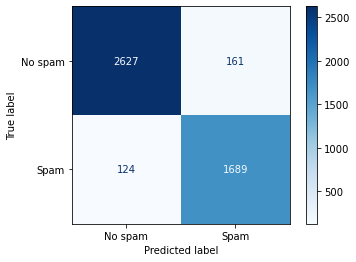

In [346]:
cm = confusion_matrix(fourth_y_true, fourth_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

#### Removing 1 most significant column (each from spam and non spam list, first and last)

In [347]:
fifth_df= df.drop(['word_freq_edu','word_freq_telnet'], axis=1)
fifth_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [349]:
fifth_X = fifth_df.loc[:, fifth_df.columns!= 'class']
fifth_Y = fifth_df['class']

In [350]:
fifth_X_train, fifth_X_test, fifth_y_train, fifth_y_test = train_test_split(fifth_X, fifth_Y, test_size=0.05, random_state=0)
fifth_model = nn_classifier(dim_input=np.shape(fifth_X_train)[1], learning_rate = 0.003)
fifth_model.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 55)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3360      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________


In [351]:
fifth_model, fifth_res, fifth_hist = cross_validation(fifth_model, fifth_X_train, fifth_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.6720 - accuracy: 0.6002 - val_loss: 0.6750 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.6185 - val_loss: 0.6604 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.6795 - val_loss: 0.5173 - val_accuracy: 0.8110
Epoch 4/50
53/53 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4214 - accuracy: 0.8455 - val_loss: 0.3546 - val_accuracy: 0.8765
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3246 - accuracy: 0.8829 - val_loss: 0.3139 - val_accuracy: 0.8857
Epoch 6/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2930 - accuracy: 0.8974 - val_loss: 0.2917 - val_accuracy: 0.8948
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2721 - accuracy: 0.9039 - val_loss: 0.2766 -

Epoch 9/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1946 - accuracy: 0.9325 - val_loss: 0.2000 - val_accuracy: 0.9299
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9317 - val_loss: 0.2032 - val_accuracy: 0.9345
Epoch 11/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.9386 - val_loss: 0.2028 - val_accuracy: 0.9299
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1870 - accuracy: 0.9359 - val_loss: 0.2045 - val_accuracy: 0.9299
Epoch 13/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9378 - val_loss: 0.2020 - val_accuracy: 0.9314
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1899 - accuracy: 0.9336 - val_loss: 0.2049 - val_accuracy: 0.9314
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9386 - val_loss: 0.2015 - val_accuracy: 0.9284
Epoch 16/50
53

53/53 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.93 - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9401 - val_loss: 0.1709 - val_accuracy: 0.9436
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9413 - val_loss: 0.1714 - val_accuracy: 0.9436
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.9363 - val_loss: 0.1854 - val_accuracy: 0.9345
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9397 - val_loss: 0.1869 - val_accuracy: 0.9345
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1800 - accuracy: 0.9375 - val_loss: 0.1742 - val_accuracy: 0.9390
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9390 - val_loss: 0.1762 - val_accuracy: 0.9329
Epoch 23/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1783 - accuracy: 0.9382 - val_loss: 0.1785 - val_

Epoch 25/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9428 - val_loss: 0.1716 - val_accuracy: 0.9451
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9443 - val_loss: 0.1714 - val_accuracy: 0.9482
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9455 - val_loss: 0.1739 - val_accuracy: 0.9421
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1744 - accuracy: 0.9416 - val_loss: 0.1707 - val_accuracy: 0.9466
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9462 - val_loss: 0.1730 - val_accuracy: 0.9451
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1780 - accuracy: 0.9401 - val_loss: 0.1738 - val_accuracy: 0.9436
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1735 - accuracy: 0.9443 - val_loss: 0.1738 - val_accuracy: 0.9436
Epoch 32/50
5

In [352]:
fifth_model,fifth_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237c6c250a0>,
 {'validation_accuracy': [0.9423604757548033,
   0.9268069533394327,
   0.9294871794871795,
   0.9230769230769231],
  'Avg_Accuracy': 0.9304328829145847})

In [353]:
fifth_preds = predict_model(fifth_model,fifth_X_test, fifth_y_test)
fifth_preds

0.9004329004329005

In [354]:
fifth_y_true = fifth_Y.astype(int).values.tolist()
fifth_y_pred = list(tf.where(fifth_model(tf.constant(fifth_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

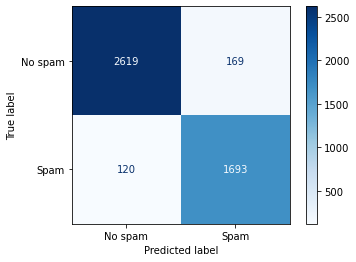

In [355]:
cm = confusion_matrix(fifth_y_true, fifth_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

#### Removing george column and money column

In [364]:
sixth_df= df.drop(['word_freq_george','word_freq_money'], axis=1)
sixth_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [365]:
sixth_X = sixth_df.loc[:, sixth_df.columns!= 'class']
sixth_Y = sixth_df['class']

In [366]:
sixth_X_train, sixth_X_test, sixth_y_train, sixth_y_test = train_test_split(sixth_X, sixth_Y, test_size=0.05, random_state=0)
sixth_model = nn_classifier(dim_input=np.shape(sixth_X_train)[1], learning_rate = 0.003)
sixth_model.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 55)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 60)                3360      
_________________________________________________________________
L2 (Dense)                   (None, 30)                1830      
_________________________________________________________________
L3 (Dense)                   (None, 10)                310       
_________________________________________________________________
L4 (Dense)                   (None, 1)                 11        
Total params: 5,511
Trainable params: 5,511
Non-trainable params: 0
_________________________________________________________________


In [367]:
sixth_model, sixth_res, sixth_hist = cross_validation(sixth_model, sixth_X_train, sixth_y_train, folds = 4, epochs = 50, batch_size = 50)

Epoch 1/50
53/53 [==============================] - 0s 5ms/step - loss: 0.6634 - accuracy: 0.6185 - val_loss: 0.6679 - val_accuracy: 0.5915
Epoch 2/50
53/53 [==============================] - 0s 2ms/step - loss: 0.6433 - accuracy: 0.6185 - val_loss: 0.6367 - val_accuracy: 0.5915
Epoch 3/50
53/53 [==============================] - 0s 2ms/step - loss: 0.5383 - accuracy: 0.7276 - val_loss: 0.4468 - val_accuracy: 0.8628
Epoch 4/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8642 - val_loss: 0.3345 - val_accuracy: 0.8765
Epoch 5/50
53/53 [==============================] - 0s 2ms/step - loss: 0.3085 - accuracy: 0.8863 - val_loss: 0.3004 - val_accuracy: 0.8933
Epoch 6/50
53/53 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8974 - val_loss: 0.2919 - val_accuracy: 0.8979
Epoch 7/50
53/53 [==============================] - 0s 2ms/step - loss: 0.2673 - accuracy: 0.9027 - val_loss: 0.2694 - val_accuracy: 0.9131
Epoch 8/50
53/53 [==

53/53 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9348 - val_loss: 0.2241 - val_accuracy: 0.9253
Epoch 10/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1977 - accuracy: 0.9336 - val_loss: 0.2236 - val_accuracy: 0.9299
Epoch 11/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1908 - accuracy: 0.9370 - val_loss: 0.2254 - val_accuracy: 0.9268
Epoch 12/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.9348 - val_loss: 0.2302 - val_accuracy: 0.9238
Epoch 13/50
53/53 [==============================] - 0s 1ms/step - loss: 0.1896 - accuracy: 0.9412 - val_loss: 0.2255 - val_accuracy: 0.9253
Epoch 14/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9355 - val_loss: 0.2515 - val_accuracy: 0.9101
Epoch 15/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9363 - val_loss: 0.2279 - val_accuracy: 0.9238
Epoch 16/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1884 - accuracy: 0.9397 - val_loss: 0.1816 - val_accuracy: 0.9345
Epoch 18/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1888 - accuracy: 0.9386 - val_loss: 0.1797 - val_accuracy: 0.9345
Epoch 19/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9382 - val_loss: 0.1826 - val_accuracy: 0.9329
Epoch 20/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.9371 - val_loss: 0.1842 - val_accuracy: 0.9314
Epoch 21/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9355 - val_loss: 0.1850 - val_accuracy: 0.9329
Epoch 22/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9367 - val_loss: 0.1809 - val_accuracy: 0.9329
Epoch 23/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1849 - accuracy: 0.9375 - val_loss: 0.1810 - val_accuracy: 0.9329
Epoch 24/50
53/53 [======

53/53 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.9401 - val_loss: 0.1698 - val_accuracy: 0.9436
Epoch 26/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9378 - val_loss: 0.1707 - val_accuracy: 0.9436
Epoch 27/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.9375 - val_loss: 0.1731 - val_accuracy: 0.9421
Epoch 28/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9375 - val_loss: 0.1712 - val_accuracy: 0.9436
Epoch 29/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1840 - accuracy: 0.9378 - val_loss: 0.1713 - val_accuracy: 0.9466
Epoch 30/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1840 - accuracy: 0.9352 - val_loss: 0.1705 - val_accuracy: 0.9436
Epoch 31/50
53/53 [==============================] - 0s 2ms/step - loss: 0.1881 - accuracy: 0.9359 - val_loss: 0.1740 - val_accuracy: 0.9436
Epoch 32/50
53/53 [======

In [368]:
sixth_model,sixth_res

(<tensorflow.python.keras.engine.functional.Functional at 0x237cf4ee7f0>,
 {'validation_accuracy': [0.9359560841720037,
   0.9249771271729186,
   0.9304029304029304,
   0.9230769230769231],
  'Avg_Accuracy': 0.928603266206194})

In [369]:
sixth_preds = predict_model(sixth_model,sixth_X_test, sixth_y_test)
sixth_preds

0.9004329004329005

In [370]:
sixth_y_true = sixth_Y.astype(int).values.tolist()
sixth_y_pred = list(tf.where(sixth_model(tf.constant(sixth_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

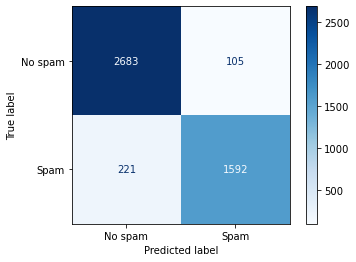

In [371]:
cm = confusion_matrix(sixth_y_true, sixth_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()

## Model with all columns:                            Avg acc = 94.3%, Test set acc = 93%
## Removing 10 most significant columns: Avg acc = 90.7%, Test set acc = 87%
## Removing 2 most significant columns:   Avg acc = 92.9%, Test set acc = 90%
## Removing 1 most significant column:     Avg acc = 93.1%, Test set acc = 90%
## Removing 4 non significant columns:     Avg acc = 93.4%, Test set acc = 90% 
## Removing 'george' and 'money' columns: acc = 92.4% , Test set acc = 88%

#### using simple model

In [373]:
seventh_df= df.drop(['word_freq_george','word_freq_money'], axis=1)
seventh_df.head(2)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.000000,0.044818,0.125490,0.0,0.032,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.023955,0.000000,0.000000,0.003407,0.006107,0.017549,1.0
1,0.046256,0.019608,0.098039,0.0,0.014,0.047619,0.028886,0.006301,0.0,0.051705,...,0.0,0.013536,0.0,0.011454,0.029985,0.002421,0.004639,0.010111,0.064895,1.0


In [374]:
seventh_X = seventh_df.loc[:, seventh_df.columns!= 'class']
seventh_Y = seventh_df['class']

In [375]:
seventh_X_train, seventh_X_test, seventh_y_train, seventh_y_test = train_test_split(seventh_X, seventh_Y, test_size=0.05, random_state=0)


In [377]:
input = np.shape(sixth_X_train)[1]
#n_output = 2
output = 1

In [378]:
x = tf.keras.layers.Input(name='X', dtype=tf.float64, shape=[input])

#layer 1: 10 inputs -> 4, sigmoid activation
l1 = tf.keras.layers.Dense(units=input, name='L1', activation='sigmoid')(x)

#layer 2: 4 inputs -> 2, softmax activation
#l2 = tf.keras.layers.Dense(units=n_output, name='L2', activation='softmax')(l1)
l2 = tf.keras.layers.Dense(units=output, name='L2', activation='sigmoid')(l1)

simple_model = tf.keras.Model(inputs=x, outputs=l2)

#specify optimizer and compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
#model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
simple_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

simple_model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, 55)]              0         
_________________________________________________________________
L1 (Dense)                   (None, 55)                3080      
_________________________________________________________________
L2 (Dense)                   (None, 1)                 56        
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
_________________________________________________________________


In [379]:
hist2 = simple_model.fit(x=seventh_X_train, y=seventh_y_train, epochs=50, batch_size=50)

Epoch 1/50
88/88 [==============================] - 0s 999us/step - loss: 0.6224 - accuracy: 0.6144
Epoch 2/50
88/88 [==============================] - 0s 1ms/step - loss: 0.5169 - accuracy: 0.7748
Epoch 3/50
88/88 [==============================] - 0s 1ms/step - loss: 0.4173 - accuracy: 0.8508
Epoch 4/50
88/88 [==============================] - 0s 1ms/step - loss: 0.3567 - accuracy: 0.8723
Epoch 5/50
88/88 [==============================] - 0s 1ms/step - loss: 0.3245 - accuracy: 0.8867
Epoch 6/50
88/88 [==============================] - 0s 1ms/step - loss: 0.3042 - accuracy: 0.8959
Epoch 7/50
88/88 [==============================] - 0s 1ms/step - loss: 0.2887 - accuracy: 0.8993
Epoch 8/50
88/88 [==============================] - 0s 1ms/step - loss: 0.2781 - accuracy: 0.9043
Epoch 9/50
88/88 [==============================] - 0s 1ms/step - loss: 0.2700 - accuracy: 0.9069
Epoch 10/50
88/88 [==============================] - 0s 1ms/step - loss: 0.2638 - accuracy: 0.9087
Epoch 11/50
88/88

In [380]:
acc = hist2.history['accuracy'][-1]


print(f'Final training accuracy  : {acc}')


Final training accuracy  : 0.9244851469993591


In [381]:
seventh_preds = predict_model(simple_model,seventh_X_test, seventh_y_test)
seventh_preds

0.8874458874458875

In [383]:
seventh_y_true = seventh_Y.astype(int).values.tolist()
seventh_y_pred = list(tf.where(simple_model(tf.constant(seventh_X)).numpy().squeeze(axis=1) < 0.5, 0, 1).numpy())

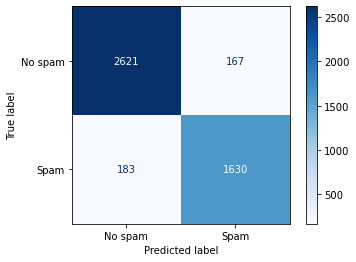

In [384]:
cm = confusion_matrix(seventh_y_true, seventh_y_pred)
disp = ConfusionMatrixDisplay (confusion_matrix = cm, display_labels = ['No spam', 'Spam'])
disp.plot(cmap = plt.cm.Blues)
plt.show()